In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from model import Market
import seaborn as sns
from agents import Firm
from model import Market

import networkx as nx


In [23]:
n_households = 500
n_firms = 50
firms_production = 12
min_income = 0
max_income = 10
min_quality = 0
max_quality = 1
decrease_price = 0.2
increase_price = 0.1
price_change = 0.01
toy_mode = False

model = Market(F=n_firms, H=n_households, firms_production=firms_production,
                min_income=min_income, max_income=max_income, 
                min_quality=min_quality, max_quality=max_quality,
                decrease_price=decrease_price, increase_price=increase_price,
                price_change=price_change, toy_mode=toy_mode )
steps = 250
for i in range(steps):
    #print('step', i)
    model.step()
    

/Users/ataberna/Documents/WWCS_2023/WWCS_2023_markets/model.py:151: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  prev = nx.adjacency_matrix(self.graphs[-1]).A
/Users/ataberna/Documents/WWCS_2023/WWCS_2023_markets/model.py:152: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  curr = nx.adjacency_matrix(self.G).A


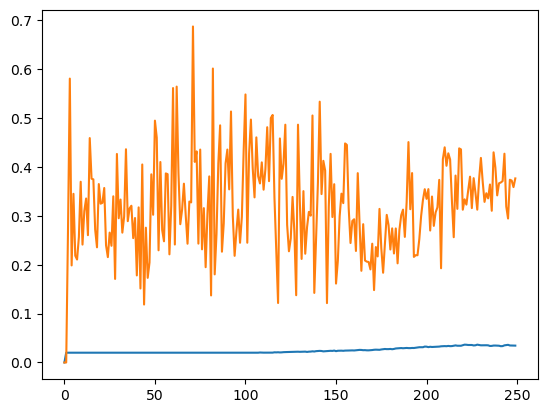

,HHI,Distance
0,0.000000,0.000000
1,0.020000,0.000000
2,0.020000,0.273167
3,0.020000,0.580829
4,0.020000,0.198574
...,...,...
245,0.036103,0.294540
246,0.034791,0.373865
247,0.034735,0.372270
248,0.034645,0.358798


In [24]:
a = model.datacollector.get_model_vars_dataframe()
a['HHI'].plot()
a['Distance'].plot()
plt.show()
a

In [25]:
# draw the graph of the last step with  Weight
# remove the nodes with no edges
'''
for i in range(1, len(model.graphs)):
    if i % 100 == 0:
        # model.graphs[i].remove_nodes_from(list(nx.isolates(model.graphs[i])))
        # color the nodes by type
        color_map = []
        node_map = []
        pos = {}
        f = 1
        h = 1
        for node in model.graphs[i]:
            if type(node) is Firm:
                color_map.append('blue')
                node_map.append(50)
                pos[node] = (1, f * 10)
                f += 1
            else:
                color_map.append('red')
                node_map.append(2)
                pos[node] = (2, h)
                h += 1
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        # draw the bipartite graph using the node color map

        nx.draw(model.graphs[i], with_labels=False, width=[model.graphs[i][u][v]['weight'] for u,v in model.graphs[i].edges()], node_color = color_map, node_size = node_map, pos=pos)
        #plt.show()
'''


"\nfor i in range(1, len(model.graphs)):\n    if i % 100 == 0:\n        # model.graphs[i].remove_nodes_from(list(nx.isolates(model.graphs[i])))\n        # color the nodes by type\n        color_map = []\n        node_map = []\n        pos = {}\n        f = 1\n        h = 1\n        for node in model.graphs[i]:\n            if type(node) is Firm:\n                color_map.append('blue')\n                node_map.append(50)\n                pos[node] = (1, f * 10)\n                f += 1\n            else:\n                color_map.append('red')\n                node_map.append(2)\n                pos[node] = (2, h)\n                h += 1\n        fig, ax = plt.subplots(1, 1, figsize=(10, 10))\n        # draw the bipartite graph using the node color map\n\n        nx.draw(model.graphs[i], with_labels=False, width=[model.graphs[i][u][v]['weight'] for u,v in model.graphs[i].edges()], node_color = color_map, node_size = node_map, pos=pos)\n        #plt.show()\n"

In [26]:
df = model.datacollector.get_agent_vars_dataframe().reset_index()

In [27]:
# for each Step, computes the HHI for each Firm
df_firm = df.loc[df['Type'] == 'Firm']
# normalize df_firm['Revenue'] in each Step
df_firm['Market_share'] = df_firm.groupby(['Step'])['Revenue'].transform(lambda x: x/x.sum())
# square the Market_share
df_firm['R'] = df_firm['Market_share']**2
# compute the HHI
HHI = df_firm.groupby(['Step'])['R'].sum()

#df_firm['HHI'] = df_firm.groupby(['Step'])['Revenue'].transform(lambda x: x**2).groupby(['Step', 'Type']).transform('sum')



/var/folders/33/dr4cqnzj0597_7n7kbsrfht8cdq0jk/T/ipykernel_30083/3487603048.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_firm['Market_share'] = df_firm.groupby(['Step'])['Revenue'].transform(lambda x: x/x.sum())
/var/folders/33/dr4cqnzj0597_7n7kbsrfht8cdq0jk/T/ipykernel_30083/3487603048.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_firm['R'] = df_firm['Market_share']**2


/var/folders/33/dr4cqnzj0597_7n7kbsrfht8cdq0jk/T/ipykernel_30083/1357000764.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  prev = nx.adjacency_matrix(graphs[i-1]).A
/var/folders/33/dr4cqnzj0597_7n7kbsrfht8cdq0jk/T/ipykernel_30083/1357000764.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  curr = nx.adjacency_matrix(graphs[i]).A


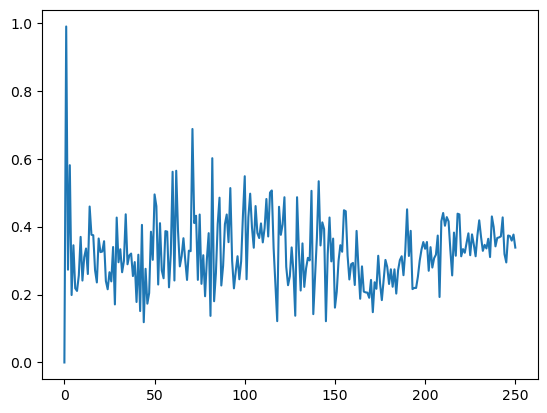

In [28]:
def change_metric(graphs):
    """
    Takes in a list of transaction graphs and returns a list of the change between each
    """
    output = [0]
    for i in range(0, len(graphs)):
        prev = nx.adjacency_matrix(graphs[i-1]).A
        curr = nx.adjacency_matrix(graphs[i]).A
        change = sum(sum(abs(curr - prev)))
        maximum = sum(sum(prev)) + sum(sum(curr))
        output.append(change/maximum)
    return output

our_metric = change_metric(model.graphs[1:])
plt.plot(our_metric)

<AxesSubplot:xlabel='Step'>

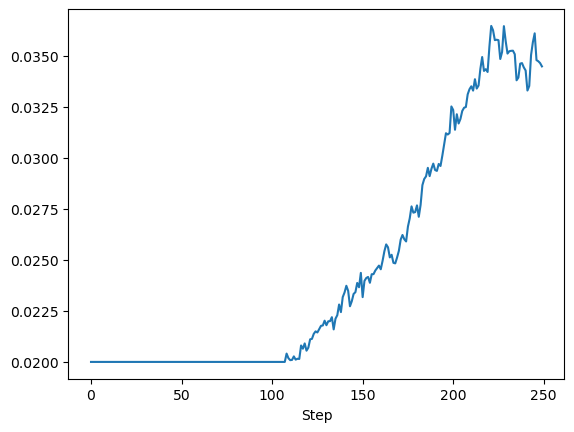

In [29]:
HHI.plot()

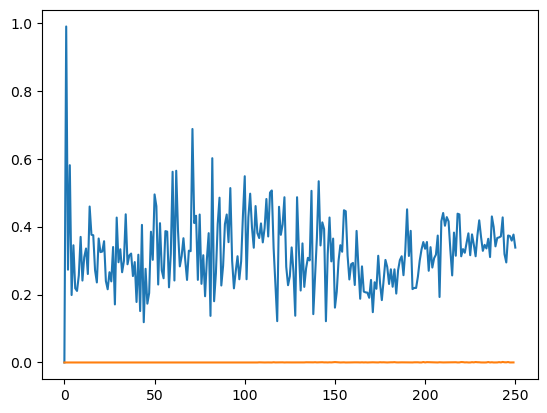

In [30]:
def compute_hhi_diff(hhi):
    hhi_diff = [0]

    for i in range(1, len(hhi)):
        change = abs(hhi[i] - hhi[i-1])
        hhi_diff.append(change)

    return hhi_diff

plt.plot(our_metric)
plt.plot(compute_hhi_diff(HHI))

<AxesSubplot:xlabel='Step', ylabel='budget'>

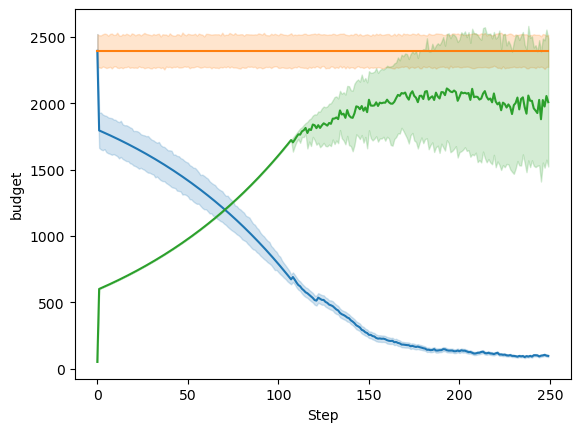

In [31]:
#sns.lineplot(data=df, y='Revenue', x='Step', estimator='sum')
sns.lineplot(data=df, y='budget', x='Step', estimator='sum')
sns.lineplot(data=df, y='Initial_budget', x='Step', estimator='sum')
sns.lineplot(data=df, y='Revenue', x='Step', estimator='sum')


<AxesSubplot:xlabel='Step', ylabel='Net_worth'>

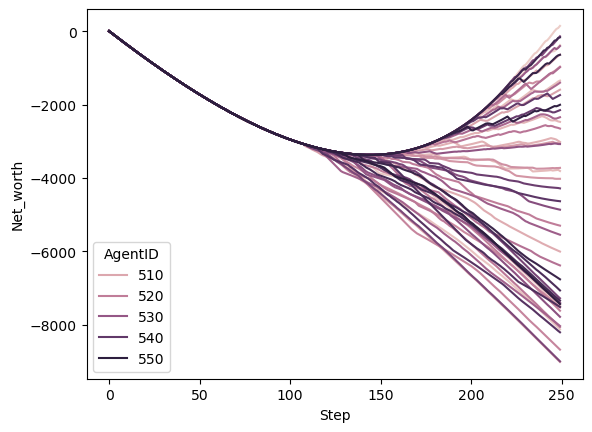

In [44]:
sns.lineplot(data=df_firm, y='Net_worth', x='Step', hue='AgentID')

<AxesSubplot:xlabel='Step', ylabel='Quality'>

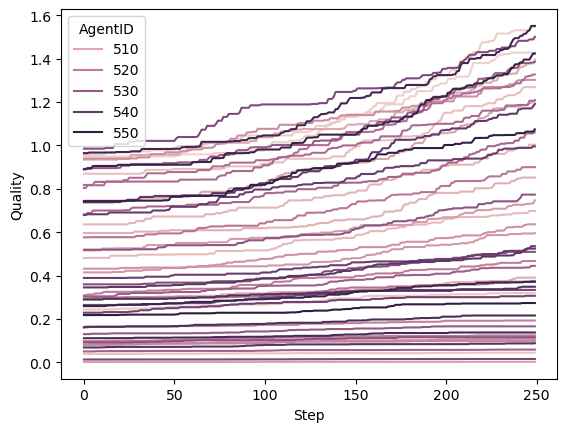

In [33]:
sns.lineplot(data=df_firm, y='Quality', x='Step', hue = 'AgentID')

<AxesSubplot:xlabel='Step', ylabel='Price'>

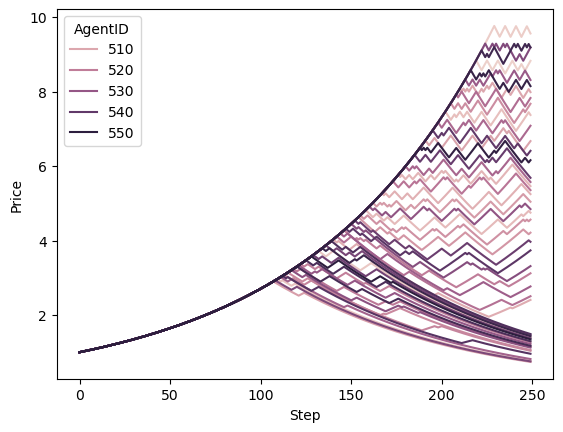

In [34]:
sns.lineplot(data=df_firm, y='Price', x='Step', hue = 'AgentID')

<AxesSubplot:xlabel='Step', ylabel='Quantity_sold'>

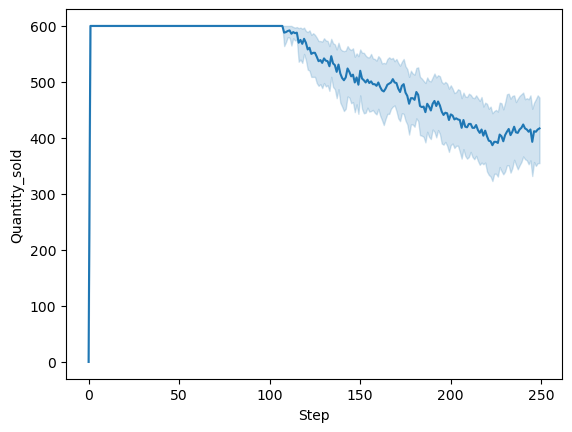

In [35]:
sns.lineplot(data=df, y='Quantity_sold', x='Step', estimator='sum')


<AxesSubplot:xlabel='Step', ylabel='Revenue'>

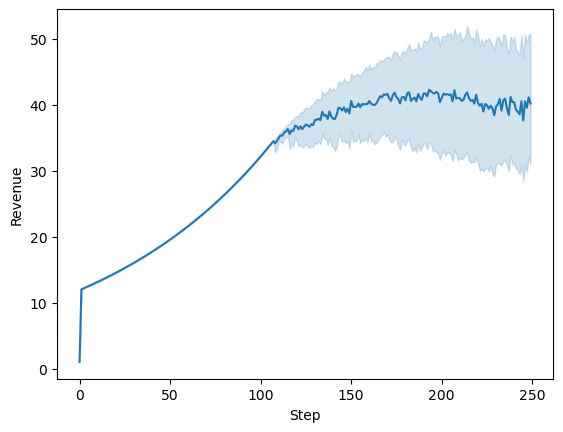

In [36]:
sns.lineplot(data=df, y='Revenue', x='Step')


<AxesSubplot:>

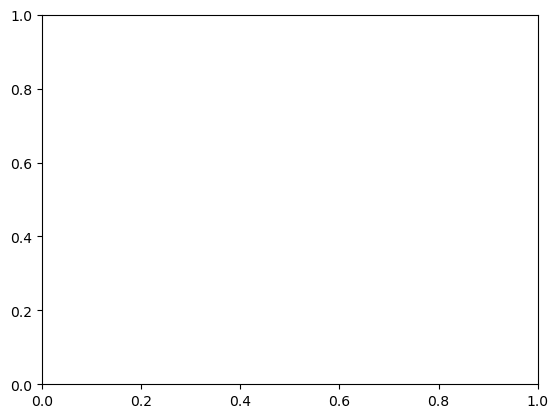

In [37]:
sns.lineplot(data=df.loc[df['AgentID'] == 1020],
             y='Revenue', x='Step', hue='AgentID')


In [38]:
df.loc[(df['Step'] == 0) & (df['Type'] == 'Household')].sort_values('budget')


,Step,AgentID,Type,Quality,Revenue,Quantity_sold,Price,Net_worth,Initial_budget,budget
382,0,383,Household,NaN,NaN,NaN,NaN,NaN,0.000600,0.000600
234,0,235,Household,NaN,NaN,NaN,NaN,NaN,0.008409,0.008409
103,0,104,Household,NaN,NaN,NaN,NaN,NaN,0.016000,0.016000
282,0,283,Household,NaN,NaN,NaN,NaN,NaN,0.022876,0.022876
206,0,207,Household,NaN,NaN,NaN,NaN,NaN,0.024392,0.024392
...,...,...,...,...,...,...,...,...,...,...
72,0,73,Household,NaN,NaN,NaN,NaN,NaN,9.850528,9.850528
440,0,441,Household,NaN,NaN,NaN,NaN,NaN,9.880991,9.880991
394,0,395,Household,NaN,NaN,NaN,NaN,NaN,9.927804,9.927804
63,0,64,Household,NaN,NaN,NaN,NaN,NaN,9.978311,9.978311


In [39]:
df.loc[(df['Step'] == 0) & (df['Type'] == 'Firm')].sort_values('Quality')


,Step,AgentID,Type,Quality,Revenue,Quantity_sold,Price,Net_worth,Initial_budget,budget
511,0,512,Firm,0.002013,1.0,0.0,1.0,0.0,NaN,NaN
534,0,535,Firm,0.013130,1.0,0.0,1.0,0.0,NaN,NaN
503,0,504,Firm,0.038328,1.0,0.0,1.0,0.0,NaN,NaN
526,0,527,Firm,0.050306,1.0,0.0,1.0,0.0,NaN,NaN
541,0,542,Firm,0.068623,1.0,0.0,1.0,0.0,NaN,NaN
516,0,517,Firm,0.080611,1.0,0.0,1.0,0.0,NaN,NaN
517,0,518,Firm,0.081348,1.0,0.0,1.0,0.0,NaN,NaN
531,0,532,Firm,0.091806,1.0,0.0,1.0,0.0,NaN,NaN
520,0,521,Firm,0.097807,1.0,0.0,1.0,0.0,NaN,NaN
544,0,545,Firm,0.111256,1.0,0.0,1.0,0.0,NaN,NaN


<AxesSubplot:xlabel='AgentID', ylabel='Quality'>

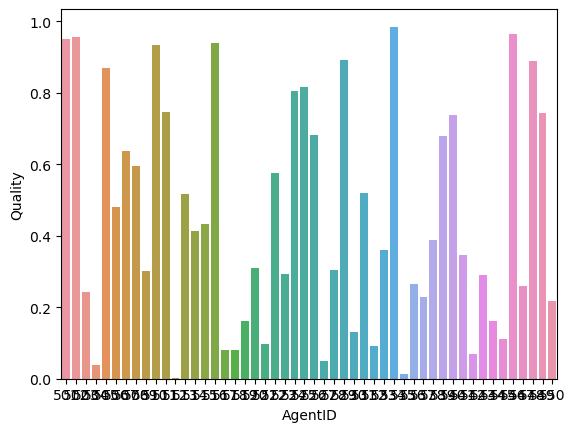

In [40]:
sns.barplot(data=df.loc[(df['Step'] == 0) & (
    df['Type'] == 'Firm')], y='Quality', x='AgentID')


In [41]:
df.loc[df['AgentID'] == 1009]


,Step,AgentID,Type,Quality,Revenue,Quantity_sold,Price,Net_worth,Initial_budget,budget


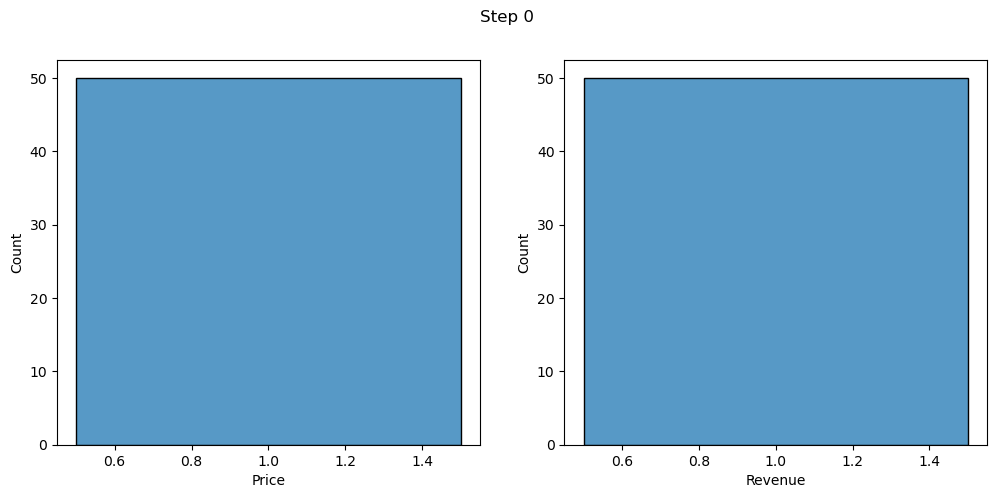

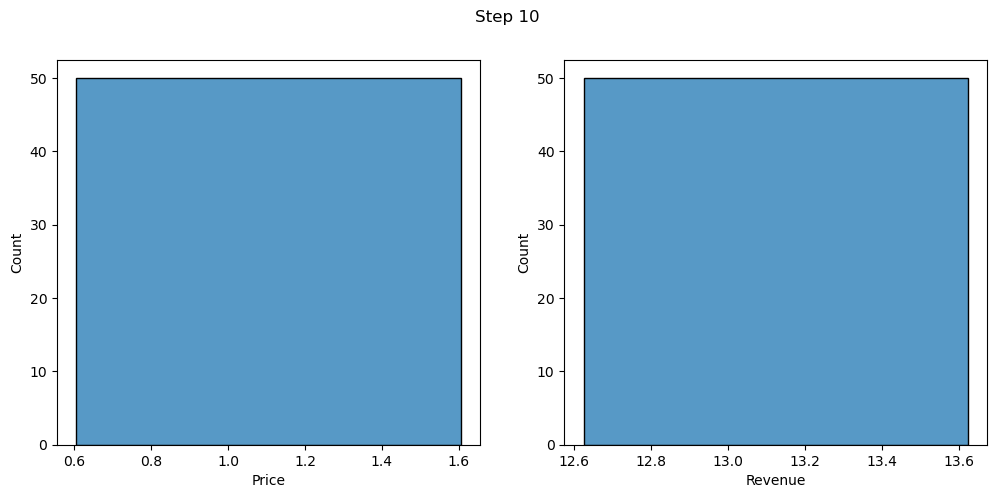

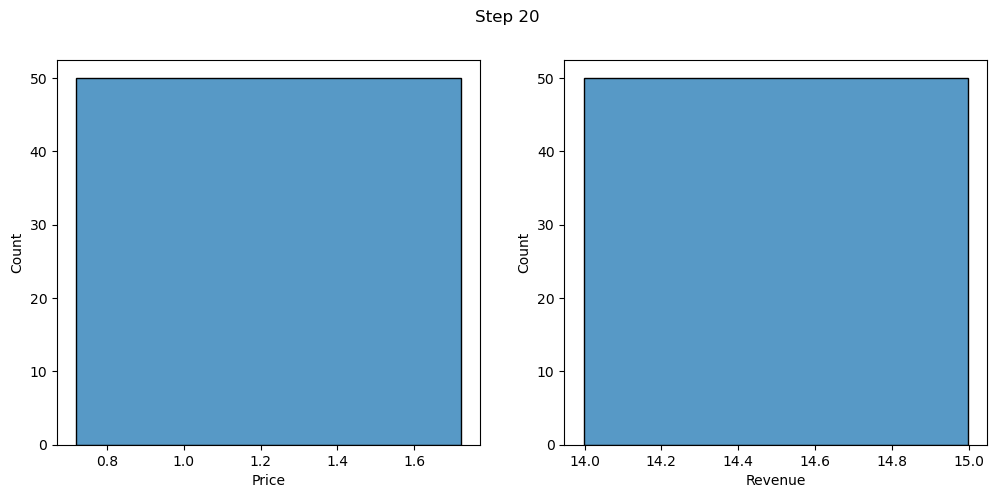

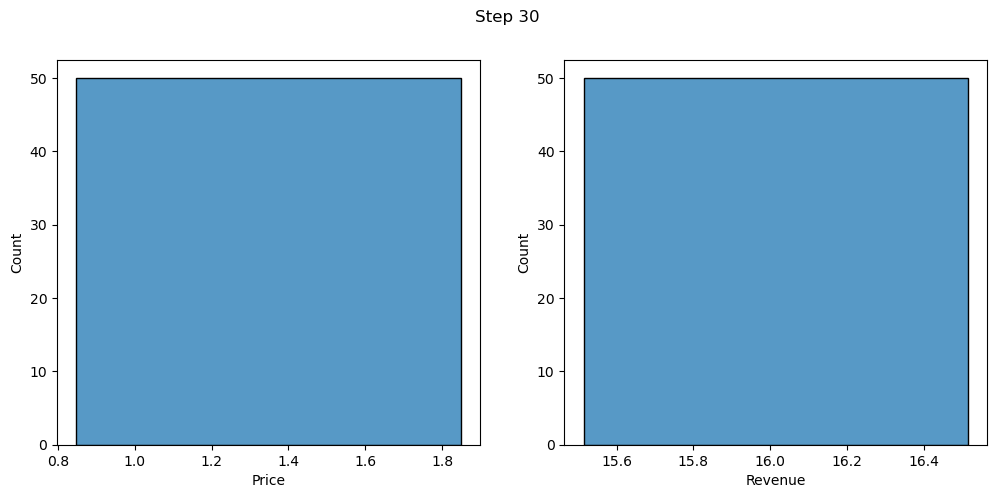

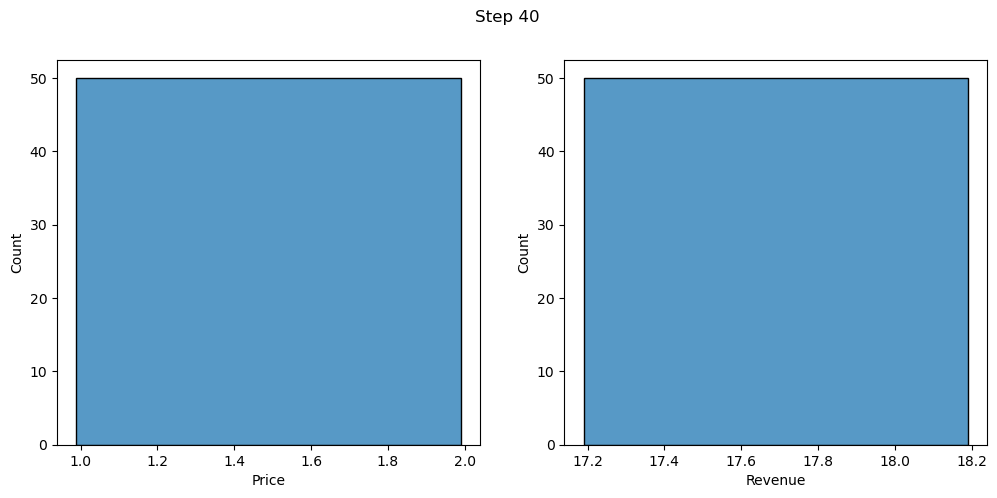

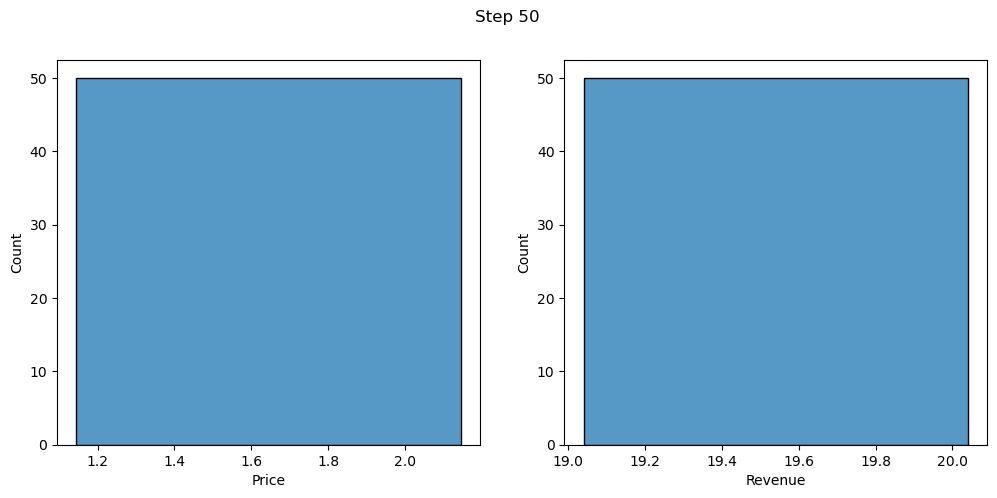

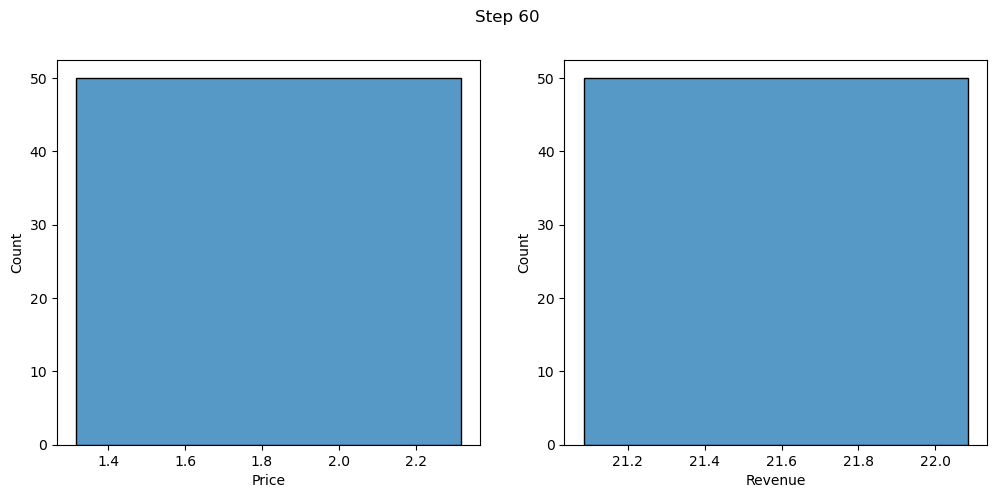

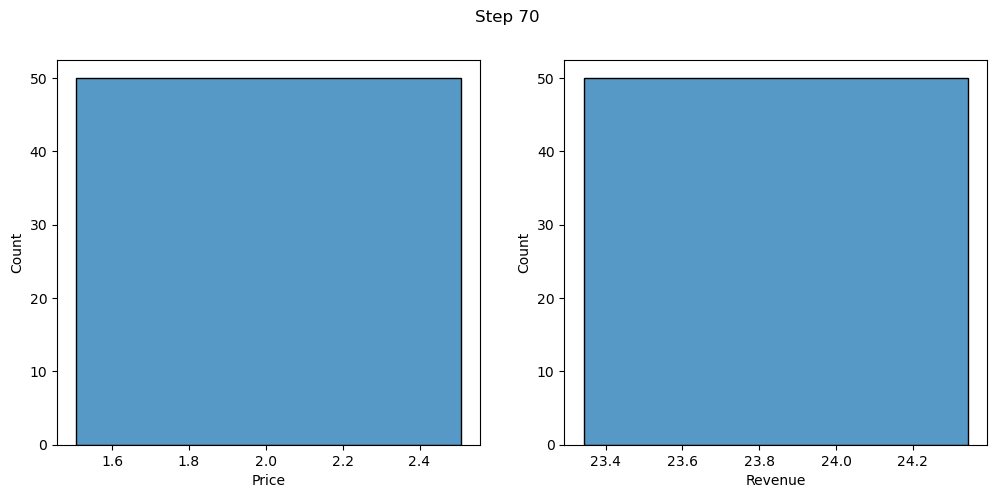

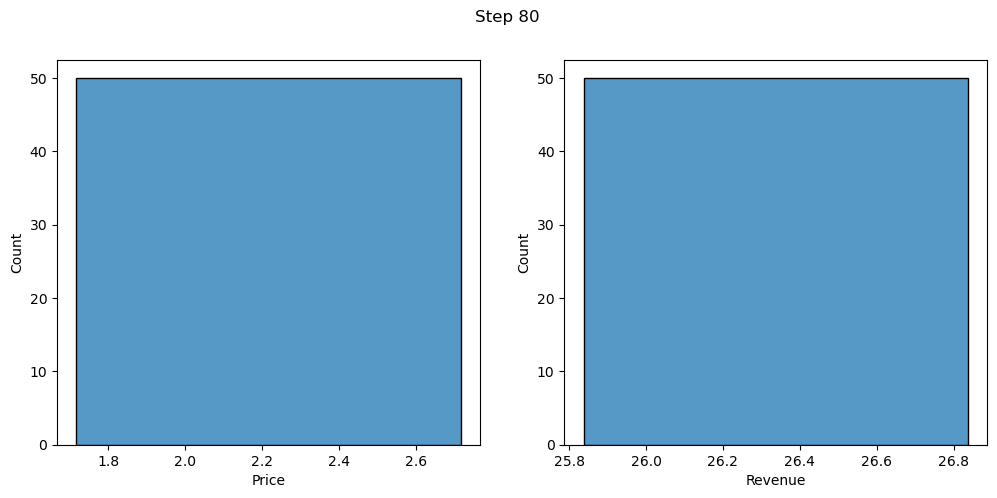

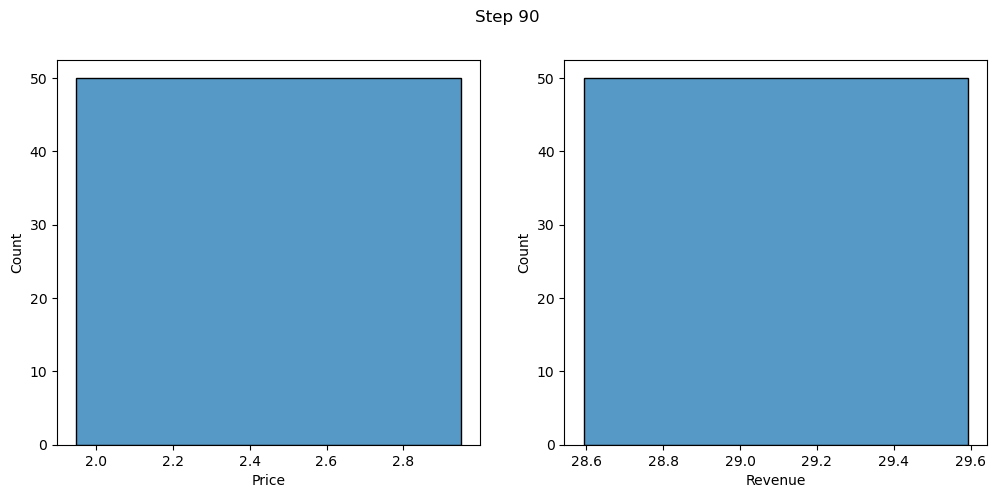

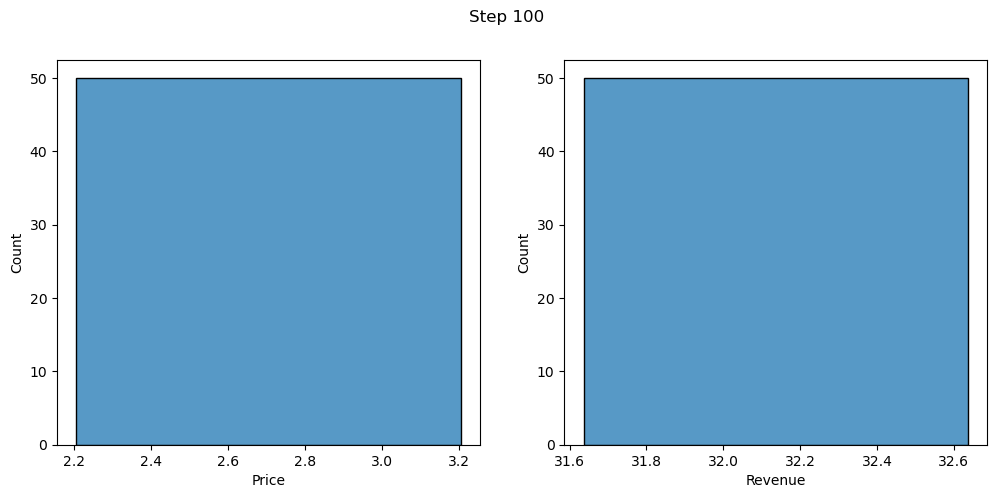

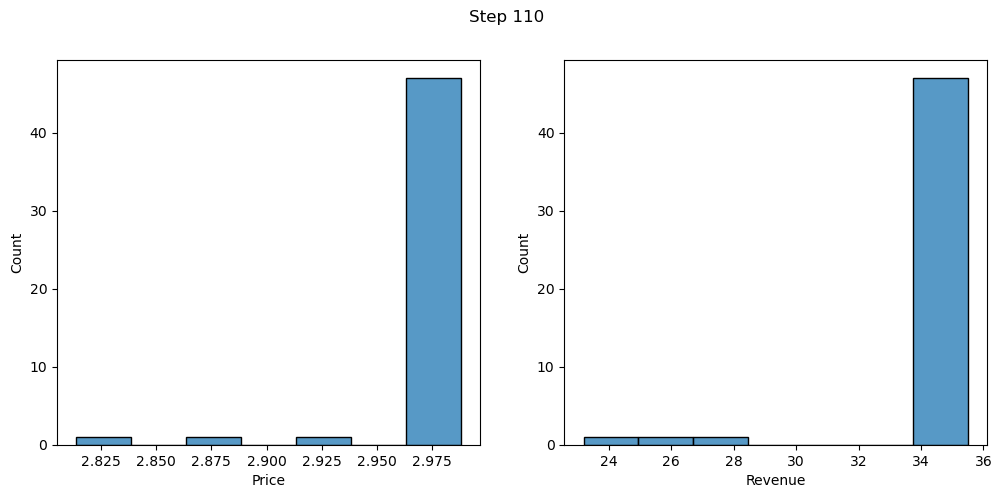

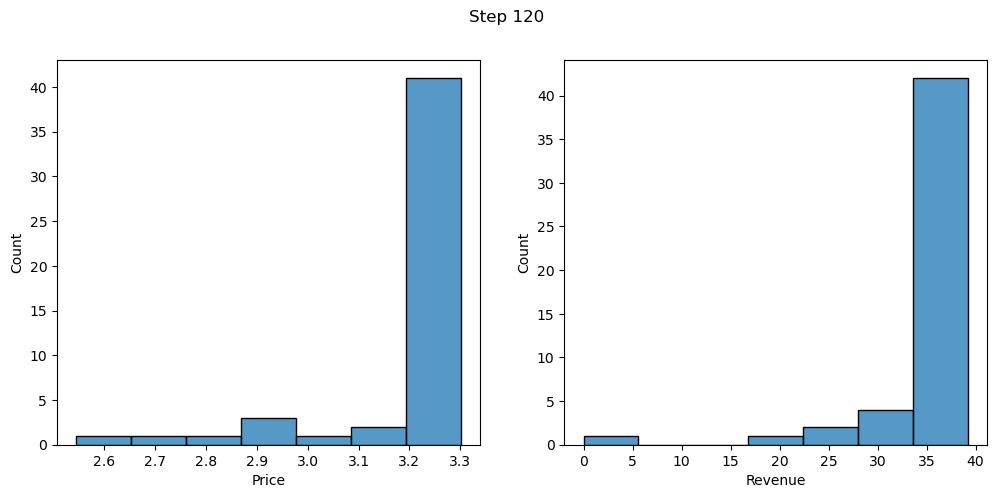

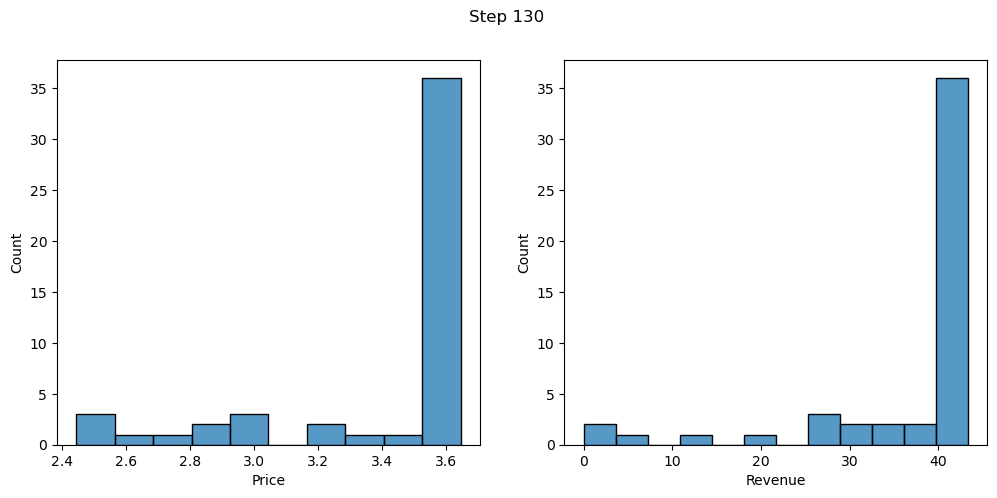

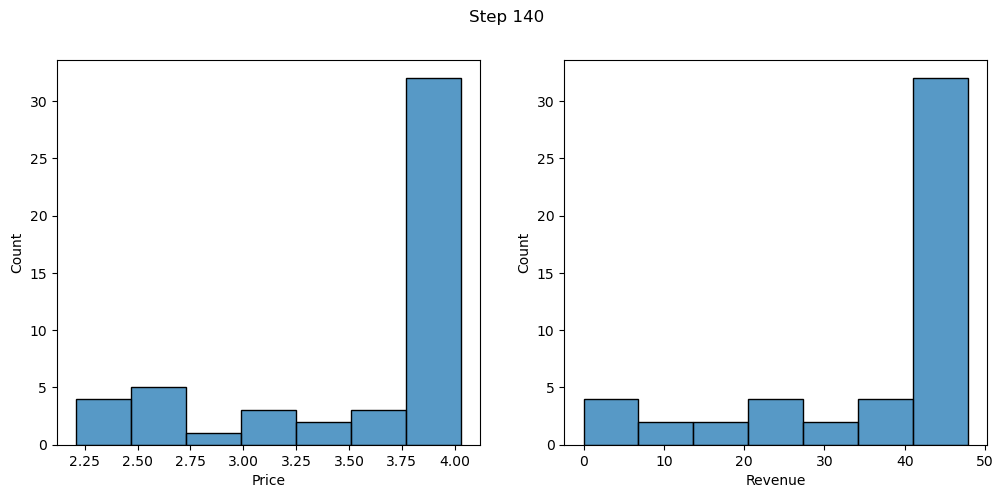

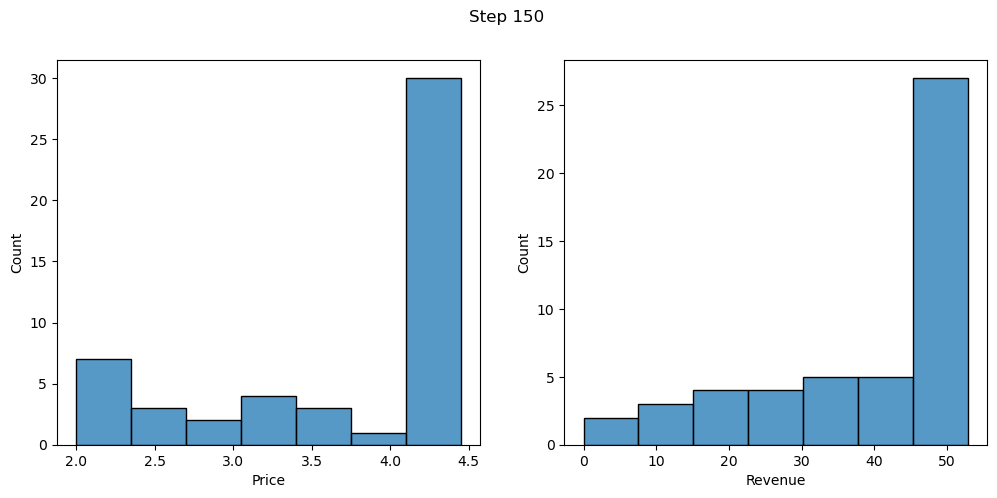

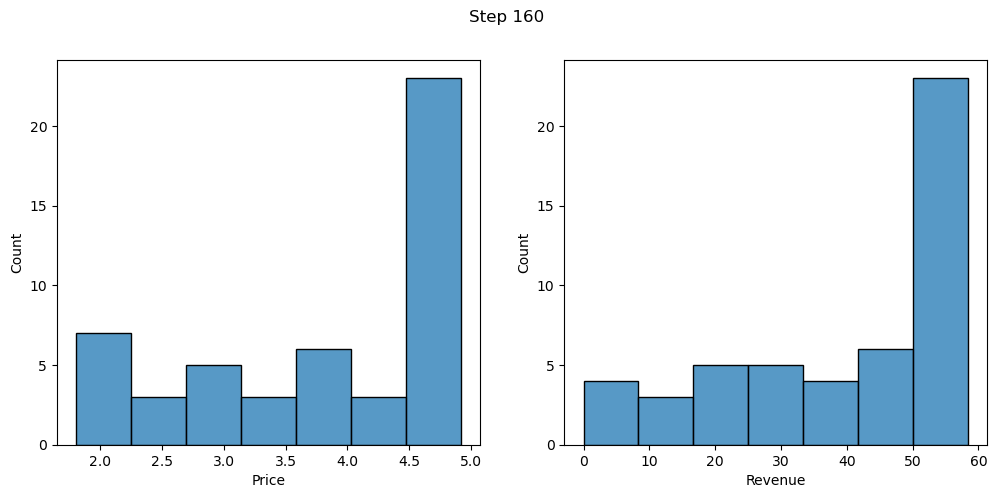

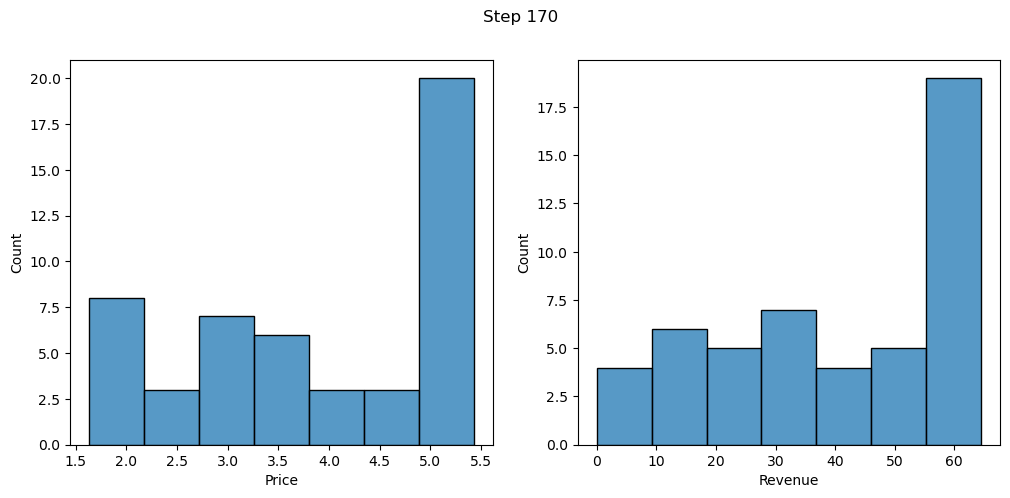

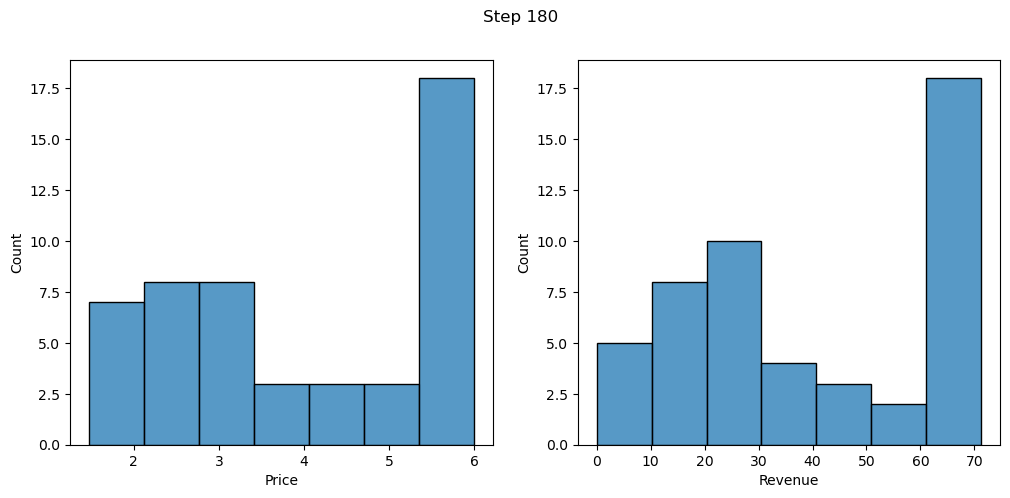

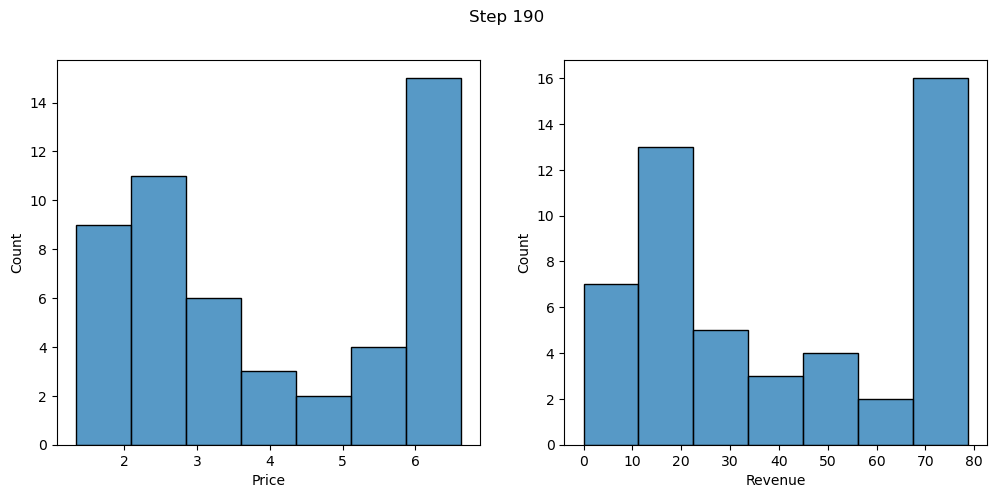

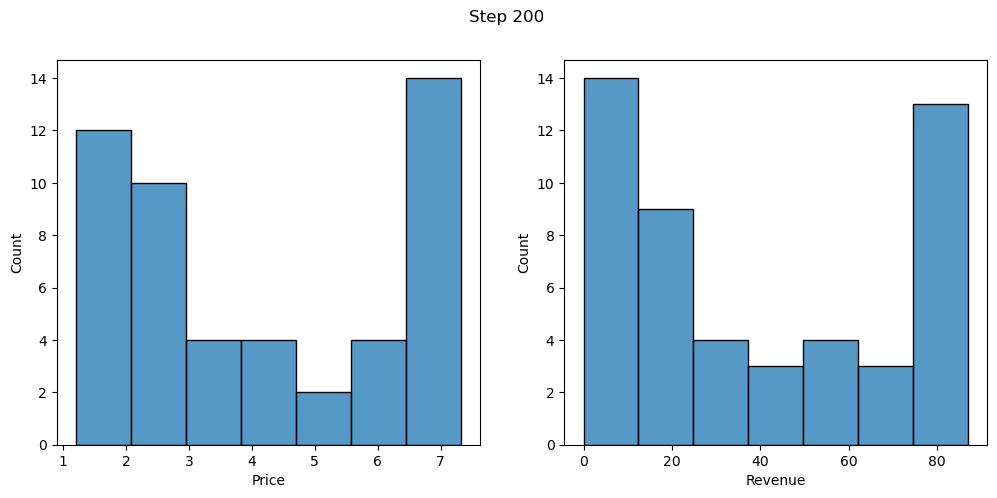

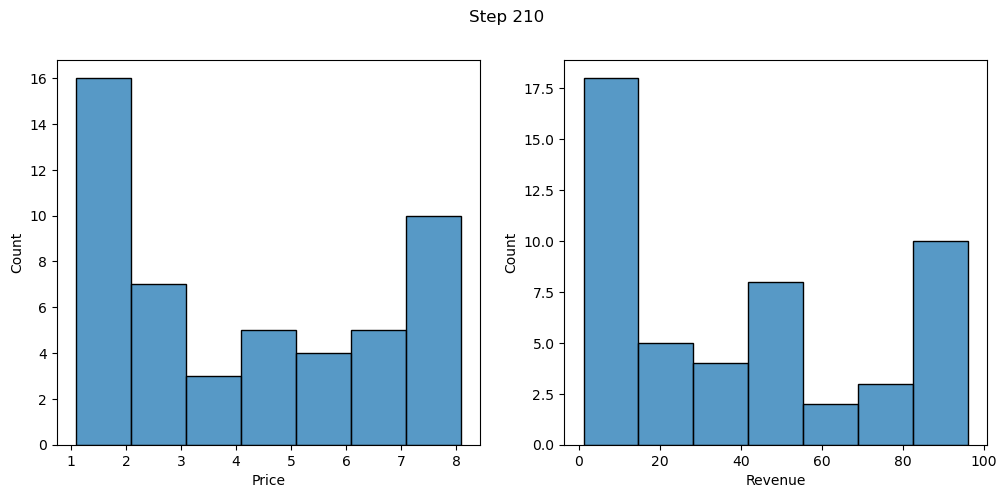

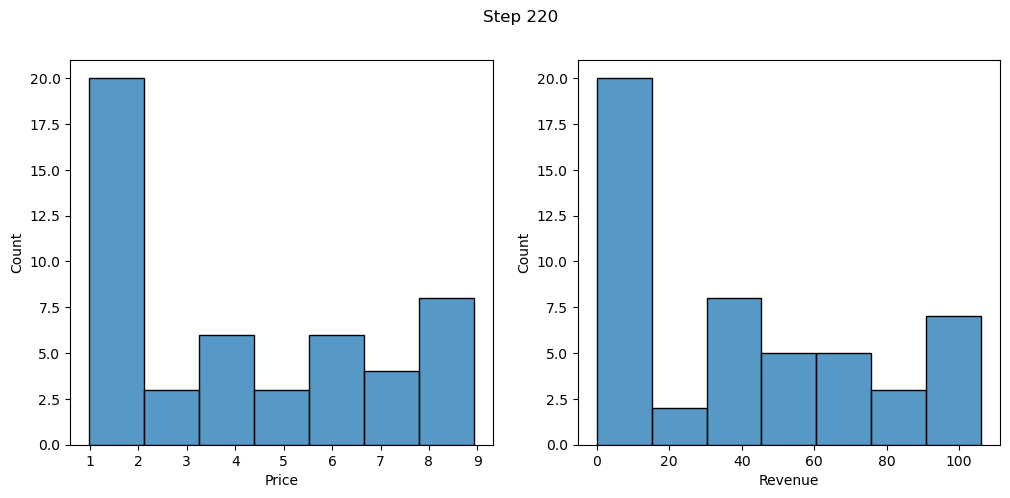

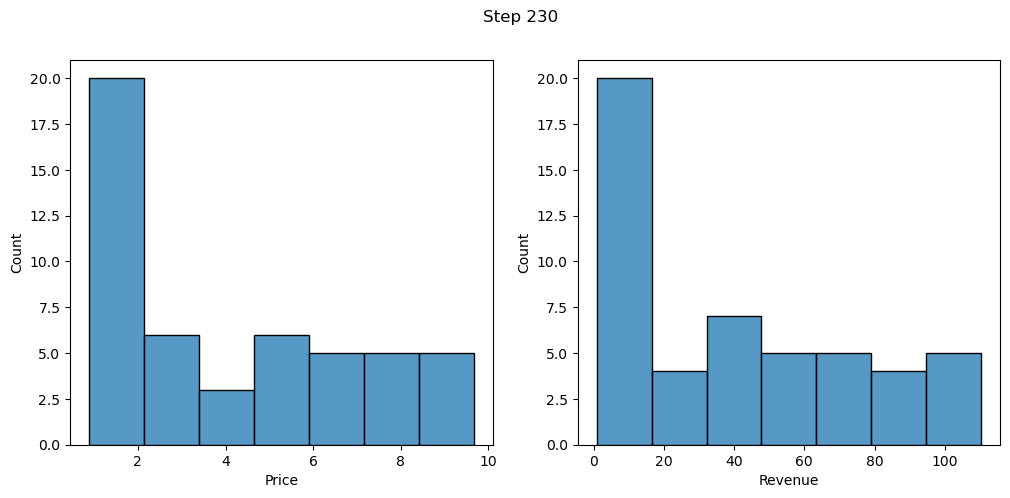

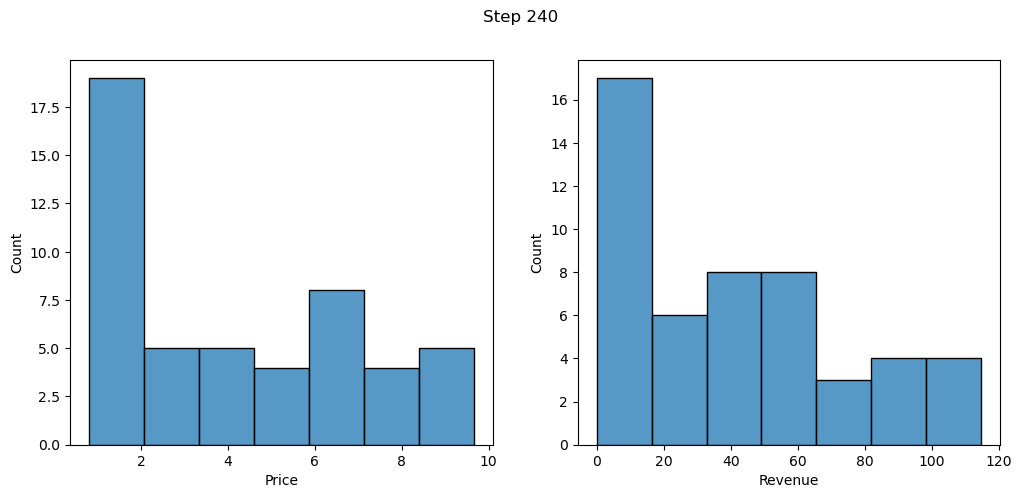

In [42]:

# for each step plot use seaborn to do a 1x2 plot with the distribution of the "Price" and "Revenue" of the firms
for i in range(steps):
    if i % 10 == 0:
        df1 = df[df["Step"] == i]
        df1 = df1[df1["Type"] == "Firm"]
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        sns.histplot(df1["Price"], ax=ax[0])
        sns.histplot(df1["Revenue"], ax=ax[1])
        # set the title of the plot to the step
        fig.suptitle("Step " + str(i))
        plt.show()


In [43]:
firms = df.loc[df['Type'] == "Firm"]
df.loc[(df['Type'] == "Firm") & (df['Step'] == 99)]['Revenue'].sum()
hhi = pd.DataFrame(data={'step': range(0,100)})
hhi = hhi.assign(volume=lambda x: df.loc[(df['Type'] == "Firm") & (df['Step'] == x.step)]['Revenue'].sum())
hhi 

ValueError: Can only compare identically-labeled Series objects